In [3]:
import librosa
import numpy as np
import os
import glob
import sys
import pandas as pd
import numpy as np
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

In [5]:
y,sr = librosa.load('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\wav_data\\A30000A1.wav')

In [18]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)
print(beat_frames)

95.703125
[22]


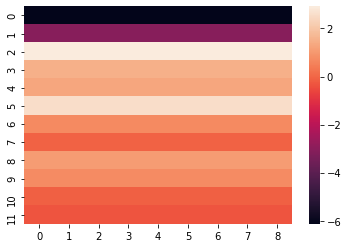

In [19]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=8192, n_mfcc=12) 
import seaborn as sns
from matplotlib import pyplot as plt
mfcc_delta = librosa.feature.delta(mfcc)
sns.heatmap(mfcc_delta)
plt.show()

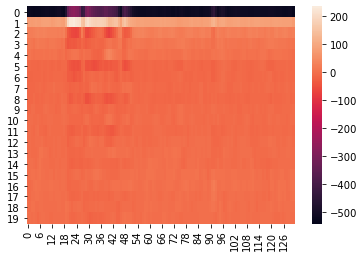

In [20]:
chromagram = librosa.feature.mfcc(y=y, sr=sr)
sns.heatmap(chromagram)
plt.show()

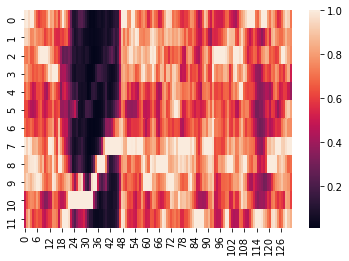

In [21]:
chromagram = librosa.feature.chroma_cqt(y=y, sr=sr)
sns.heatmap(chromagram)
plt.show()

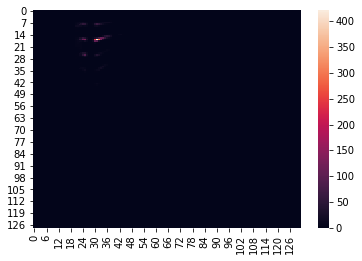

In [22]:
chromagram = librosa.feature.melspectrogram(y=y, sr=sr)
sns.heatmap(chromagram)
plt.show()

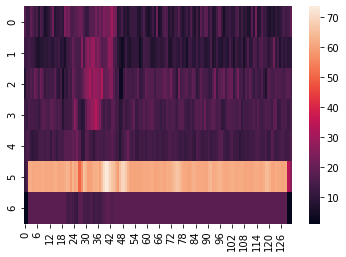

In [23]:
chromagram = librosa.feature.spectral_contrast(y=y, sr=sr)
sns.heatmap(chromagram)
plt.show()

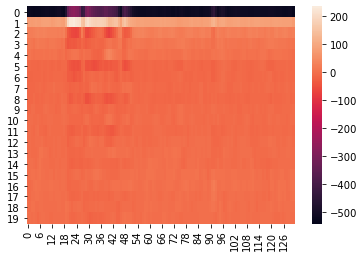

In [58]:
chromagram = librosa.feature.mfcc(y=y, sr=sr)
sns.heatmap(chromagram)
plt.show()

In [25]:
len(chromagram)

20

In [10]:
X, sample_rate = librosa.core.load('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\wav_data\\A30000A1.wav')
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)

In [11]:
import librosa
import numpy as np

def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

dirname = "data"

if not os.path.isdir(dirname):
    os.mkdir(dirname)


csv_files = glob.glob("*.csv")

for j, csv_file in enumerate(csv_files):
    print("[+] Preprocessing", csv_file)
    df = pd.read_csv(csv_file)
    # only take filename and gender columns
    new_df = df[["filename", "gender"]]
    print("Previously:", len(new_df), "rows")
    # take only male & female genders (i.e droping NaNs & 'other' gender)
    new_df = new_df[np.logical_or(new_df['gender'] == 'female', new_df['gender'] == 'male')]
    print("Now:", len(new_df), "rows")
    new_csv_file = os.path.join(dirname, csv_file)
    # save new preprocessed CSV 
    new_df.to_csv(new_csv_file, index=False)
    # get the folder name
    folder_name, _ = csv_file.split(".")
    audio_files = glob.glob(f"{folder_name}/{folder_name}/*")
    all_audio_filenames = set(new_df["filename"])
    for i, audio_file in tqdm(list(enumerate(audio_files)), f"Extracting features of {folder_name}"):
        splited = os.path.split(audio_file)
        # audio_filename = os.path.join(os.path.split(splited[0])[-1], splited[-1])
        audio_filename = f"{os.path.split(splited[0])[-1]}/{splited[-1]}"
        # print("audio_filename:", audio_filename)
        if audio_filename in all_audio_filenames:
            # print("Copyying", audio_filename, "...")
            src_path = f"{folder_name}/{audio_filename}"
            target_path = f"{dirname}/{audio_filename}"
            #create that folder if it doesn't exist
            if not os.path.isdir(os.path.dirname(target_path)):
                os.mkdir(os.path.dirname(target_path))
            features = extract_feature(src_path, mel=True)
            target_filename = target_path.split(".")[0]
            np.save(target_filename, features)
            # shutil.copyfile(src_path, target_path)

In [12]:
female = pd.read_csv('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\female.txt')
male = pd.read_csv('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\male.txt')

In [13]:
gender = female.join(male)

In [14]:
gender

,female:,male:
0,A30000A1.wav,A30001A1.wav
1,A30000A2.wav,A30001A2.wav
2,A30000A3.wav,A30001A3.wav
3,A30000A4.wav,A30001A4.wav
4,A30000A5.wav,A30001A5.wav
...,...,...
97,A30002X2.wav,A30003X2.wav
98,A30002X3.wav,A30003X3.wav
99,A30002X4.wav,A30003X4.wav
100,A30002X5.wav,A30003X5.wav


In [16]:
array_female = []
for i in range(len(female)):
    path_female = 'C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\wav_data\\'+female.iat[i,0]
    np.save('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\numpy_wav_data\\'+'f'+str(i), extract_feature(path_female, tonnetz = True))
    array_female.append('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\numpy_wav_data\\'+'f'+str(i)+'.npy')

C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=1016
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=897
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=926
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=938
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=947
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=978
  retur

In [17]:
array_male = []
for i in range(len(male)):
    path_male = 'C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\wav_data\\'+male.iat[i,0]
    np.save('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\numpy_wav_data\\'+'m'+str(i), extract_feature(path_male, tonnetz = True))
    array_male.append('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\numpy_wav_data\\'+'m'+str(i)+'.npy')

C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=985
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=905
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=890
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=922
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=900
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=1008
  retur

In [18]:
df_female = pd.DataFrame(array_female)

In [19]:
df_female["gender"] = ["female" for i in range(len(female))]

In [20]:
df_female.rename(columns={ 0 : "path_to_file"})

,path_to_file,gender
0,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
1,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
2,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
3,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
4,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
...,...,...
97,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
98,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
99,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
100,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female


In [25]:
df_male = pd.DataFrame(array_male)

In [26]:
df_male.rename(columns={ 0 : "path_to_file"})

,path_to_file
0,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...
1,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...
2,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...
3,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...
4,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...
...,...
97,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...
98,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...
99,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...
100,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...


In [27]:
df_male["gender"] = ["male" for i in range(len(male))]

In [28]:
 df = df_female.append(df_male, ignore_index=True) 

In [29]:
df.rename(columns={ 0 : "filename"})

,filename,gender
0,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
1,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
2,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
3,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
4,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,female
...,...,...
199,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,male
200,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,male
201,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,male
202,C:\Users\Splayser_lab\OneDrive\Рабочий стол\ст...,male


In [190]:
df.to_csv('C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\dffg.csv')  

In [30]:
# get total samples
n_samples = len(df)
# get total male samples
n_male_samples = len(df[df['gender'] == 'male'])
# get total female samples
n_female_samples = len(df[df['gender'] == 'female'])
print("Total samples:", n_samples)
print("Total male samples:", n_male_samples)
print("Total female samples:", n_female_samples)

Total samples: 204
Total male samples: 102
Total female samples: 102


In [31]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (df[0], gender) in tqdm.tqdm(enumerate(zip(df[0], df['gender'])), "Loading data", total=n_samples):
        features = np.load(df.iat[i,0])
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [32]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [33]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

In [34]:
def create_model(vector_length=128):
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [35]:
# construct the model
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1

In [36]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
3/3 [==============================] - 1s 118ms/step - loss: 0.7978 - accuracy: 0.4878 - val_loss: 0.9173 - val_accuracy: 0.2632
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 0.7489 - accuracy: 0.5061 - val_loss: 0.8282 - val_accuracy: 0.2632
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7109 - accuracy: 0.5488 - val_loss: 0.7608 - val_accuracy: 0.2632
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.7195 - accuracy: 0.5183 - val_loss: 0.7571 - val_accuracy: 0.2632
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6848 - accuracy: 0.5915 - val_loss: 0.7320 - val_accuracy: 0.2632
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.7094 - accuracy: 0.4695 - val_loss: 0.7191 - val_accuracy: 0.2632
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.7135 - accuracy: 0.4817 - val_loss: 0.7147 - val_accuracy: 0.2632
Epoch 8/100
3/3 [==

In [37]:
# save the model to a file
model.save("C:\\Users\\Splayser_lab\\OneDrive\\Рабочий стол\\стц\\model\\model.h5")

In [38]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 21 samples...
Loss: 0.6920
Accuracy: 52.38%
